In [ ]:
# Decision tree
# textual overview
# https://www.w3schools.com/python/python_ml_decision_tree.asp
# from scratch !
# https://github.com/Eligijus112/decision-tree-python
# https://scikit-learn.org/1.2/auto_examples/tree/plot_unveil_tree_structure.html
# operating on Titanic data
# Feb 2022

In [ ]:
import os, sys
import numpy
import pandas

import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
class Node: 
    """
    Class for creating the nodes for a decision tree 
    """
    def __init__(
        self, 
        Y: list,
        X: pandas.DataFrame,
        min_samples_split=None,
        max_depth=None,
        depth=None,
        node_type=None,
        rule=None
    ):
        # Saving the data to the node 
        self.Y = Y 
        self.X = X

        # Saving the hyper parameters
        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5

        # Default current depth of node 
        self.depth = depth if depth else 0

        # Extracting all the features
        self.features = list(self.X.columns)

        # Type of node 
        self.node_type = node_type if node_type else 'root'

        # Rule for spliting 
        self.rule = rule if rule else ""

        # Calculating the counts of Y in the node 
        self.counts = Counter(Y)

        # Getting the GINI impurity based on the Y distribution
        self.gini_impurity = self.get_GINI()

        # Sorting the counts and saving the final prediction of the node 
        counts_sorted = list(sorted(self.counts.items(), key=lambda item: item[1]))

        # Getting the last item
        yhat = None
        if len(counts_sorted) > 0:
            yhat = counts_sorted[-1][0]

        # Saving to object attribute. This node will predict the class with the most frequent class
        self.yhat = yhat 

        # Saving the number of observations in the node 
        self.n = len(Y)

        # Initiating the left and right nodes as empty nodes
        self.left = None 
        self.right = None 

        # Default values for splits
        self.best_feature = None 
        self.best_value = None 

    @staticmethod
    def GINI_impurity(y1_count: int, y2_count: int) -> float:
        """
        Given the observations of a binary class calculate the GINI impurity
        """
        # Ensuring the correct types
        if y1_count is None:
            y1_count = 0

        if y2_count is None:
            y2_count = 0

        # Getting the total observations
        n = y1_count + y2_count
        
        # If n is 0 then we return the lowest possible gini impurity
        if n == 0:
            return 0.0

        # Getting the probability to see each of the classes
        p1 = y1_count / n
        p2 = y2_count / n
        
        # Calculating GINI 
        gini = 1 - (p1 ** 2 + p2 ** 2)
        
        # Returning the gini impurity
        return gini

    @staticmethod
    def ma(x: numpy.array, window: int) -> numpy.array:
        """
        Calculates the moving average of the given list. 
        """
        return numpy.convolve(x, numpy.ones(window), 'valid') / window

    def get_GINI(self):
        """
        Function to calculate the GINI impurity of a node 
        """
        # Getting the 0 and 1 counts
        y1_count, y2_count = self.counts.get(0, 0), self.counts.get(1, 0)

        # Getting the GINI impurity
        return self.GINI_impurity(y1_count, y2_count)

    def best_split(self) -> tuple:
        """
        Given the X features and Y targets calculates the best split 
        for a decision tree
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y

        # Getting the GINI impurity for the base input 
        GINI_base = self.get_GINI()

        # Finding which split yields the best GINI gain 
        max_gain = 0

        # Default best feature and split
        best_feature = None
        best_value = None

        for feature in self.features:
            # Droping missing values
            Xdf = df.dropna().sort_values(feature)

            # Sorting the values and getting the rolling average
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                # Spliting the dataset 
                left_counts = Counter(Xdf[Xdf[feature]<value]['Y'])
                right_counts = Counter(Xdf[Xdf[feature]>=value]['Y'])

                # Getting the Y distribution from the dicts
                y0_left, y1_left, y0_right, y1_right = left_counts.get(0, 0), left_counts.get(1, 0), right_counts.get(0, 0), right_counts.get(1, 0)

                # Getting the left and right gini impurities
                gini_left = self.GINI_impurity(y0_left, y1_left)
                gini_right = self.GINI_impurity(y0_right, y1_right)

                # Getting the obs count from the left and the right data splits
                n_left = y0_left + y1_left
                n_right = y0_right + y1_right

                # Calculating the weights for each of the nodes
                w_left = n_left / (n_left + n_right)
                w_right = n_right / (n_left + n_right)

                # Calculating the weighted GINI impurity
                wGINI = w_left * gini_left + w_right * gini_right

                # Calculating the GINI gain 
                GINIgain = GINI_base - wGINI

                # Checking if this is the best split so far 
                if GINIgain > max_gain:
                    best_feature = feature
                    best_value = value 

                    # Setting the best gain to the current one 
                    max_gain = GINIgain

        return (best_feature, best_value)

    def grow_tree(self):
        """
        Recursive method to create the decision tree
        """
        # Making a df from the data 
        df = self.X.copy()
        df['Y'] = self.Y

        # If there is GINI to be gained, we split further 
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):

            # Getting the best split 
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                # Saving the best split to the current node 
                self.best_feature = best_feature
                self.best_value = best_value

                # Getting the left and right nodes
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()

                # Creating the left and right nodes
                left = Node(
                    left_df['Y'].values.tolist(), 
                    left_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"{best_feature} <= {round(best_value, 3)}"
                    )

                self.left = left 
                self.left.grow_tree()

                right = Node(
                    right_df['Y'].values.tolist(), 
                    right_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"{best_feature} > {round(best_value, 3)}"
                    )

                self.right = right
                self.right.grow_tree()

    def print_info(self, width=4):
        """
        Method to print the infromation about the tree
        """
        # Defining the number of spaces 
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const
        
        if self.node_type == 'root':
            print("Root")
        else:
            print(f"|{spaces} Split rule: {self.rule}")
        print(f"{' ' * const}   | GINI impurity of the node: {round(self.gini_impurity, 2)}")
        print(f"{' ' * const}   | Class distribution in the node: {dict(self.counts)}")
        print(f"{' ' * const}   | Predicted class: {self.yhat}")   

    def print_tree(self):
        """
        Prints the whole tree from the current node to the bottom
        """
        self.print_info() 
        
        if self.left is not None: 
            self.left.print_tree()
        
        if self.right is not None:
            self.right.print_tree()

    def predict(self, X:pandas.DataFrame):
        """
        Batch prediction method
        """
        predictions = []

        for _, x in X.iterrows():
            values = {}
            for feature in self.features:
                values.update({feature: x[feature]})
        
            predictions.append(self.predict_obs(values))
        
        return predictions

    def predict_obs(self, values: dict) -> int:
        """
        Method to predict the class given a set of features
        """
        cur_node = self
        while cur_node.depth < cur_node.max_depth:
            # Traversing the nodes all the way to the bottom
            best_feature = cur_node.best_feature
            best_value = cur_node.best_value

            if cur_node.n < cur_node.min_samples_split:
                break 

            if (values.get(best_feature) < best_value):
                if self.left is not None:
                    cur_node = cur_node.left
            else:
                if self.right is not None:
                    cur_node = cur_node.right
            
        return cur_node.yhat

In [ ]:
if __name__ == '__main__':

    # Reading data
    source = 'https://raw.githubusercontent.com/realtechsupport/CriticalMachineLearning/main/various_datasets/titanic_train.csv'
    d = pandas.read_csv(source)[['Age', 'Fare', 'Survived']].dropna()

    # Constructing the X and Y matrices
    X = d[['Age', 'Fare']]
    Y = d['Survived'].values.tolist()

    # Initiating the Node
    root = Node(Y, X, max_depth=3, min_samples_split=100)

    # Getting teh best split
    root.grow_tree()

    # Printing the tree information 
    root.print_tree()


In [ ]:
    # Predicting 
    Xsubset = X.copy()
    Xsubset['yhat'] = root.predict(Xsubset)
    print(Xsubset)

In [ ]:
# Now build the decision tree classifier with scikit learn

from sklearn.tree import DecisionTreeClassifier              
from sklearn.model_selection import train_test_split         
from sklearn import metrics                                  #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) # 70% training and 30% test

[Text(0.5, 0.875, 'X[1] <= 16.4\ngini = 0.487\nsamples = 499\nvalue = [290, 209]'),
 Text(0.25, 0.625, 'X[0] <= 14.25\ngini = 0.399\nsamples = 262\nvalue = [190, 72]'),
 Text(0.125, 0.375, 'X[0] <= 1.5\ngini = 0.298\nsamples = 11\nvalue = [2, 9]'),
 Text(0.0625, 0.125, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.1875, 0.125, 'gini = 0.375\nsamples = 8\nvalue = [2, 6]'),
 Text(0.375, 0.375, 'X[1] <= 9.288\ngini = 0.376\nsamples = 251\nvalue = [188, 63]'),
 Text(0.3125, 0.125, 'gini = 0.317\nsamples = 152\nvalue = [122, 30]'),
 Text(0.4375, 0.125, 'gini = 0.444\nsamples = 99\nvalue = [66, 33]'),
 Text(0.75, 0.625, 'X[1] <= 52.277\ngini = 0.488\nsamples = 237\nvalue = [100, 137]'),
 Text(0.625, 0.375, 'X[1] <= 19.856\ngini = 0.499\nsamples = 139\nvalue = [72, 67]'),
 Text(0.5625, 0.125, 'gini = 0.26\nsamples = 13\nvalue = [2, 11]'),
 Text(0.6875, 0.125, 'gini = 0.494\nsamples = 126\nvalue = [70, 56]'),
 Text(0.875, 0.375, 'X[0] <= 63.5\ngini = 0.408\nsamples = 98\nvalue = [28, 70]

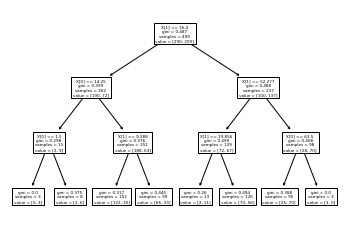

In [ ]:
#https://towardsdatascience.com/introduction-to-decision-tree-classifiers-from-scikit-learn-32cd5d23f4d

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
# Plot
tree.plot_tree(clf)

In [ ]:
# Show the tree
print(tree.export_text(clf))

|--- feature_1 <= 16.40
|   |--- feature_0 <= 14.25
|   |   |--- feature_0 <= 1.50
|   |   |   |--- class: 1
|   |   |--- feature_0 >  1.50
|   |   |   |--- class: 1
|   |--- feature_0 >  14.25
|   |   |--- feature_1 <= 9.29
|   |   |   |--- class: 0
|   |   |--- feature_1 >  9.29
|   |   |   |--- class: 0
|--- feature_1 >  16.40
|   |--- feature_1 <= 52.28
|   |   |--- feature_1 <= 19.86
|   |   |   |--- class: 1
|   |   |--- feature_1 >  19.86
|   |   |   |--- class: 0
|   |--- feature_1 >  52.28
|   |   |--- feature_0 <= 63.50
|   |   |   |--- class: 1
|   |   |--- feature_0 >  63.50
|   |   |   |--- class: 0



In [ ]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)
print(y_pred)